In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 184)
(772408, 8)
validation
(101248, 184)
(101248, 8)
test
(98888, 184)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 184)]             0         


 dense (Dense)               (None, 1024)              189440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 879496 (3.36 MB)


Trainable params: 879496 (3.36 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:33 - loss: 1.7283 - STD: 0.0838 - MAE: 0.1975

 7/78 [=>............................] - ETA: 0s - loss: 1.4203 - STD: 0.1881 - MAE: 0.1489  

13/78 [====>.........................] - ETA: 0s - loss: 1.3853 - STD: 0.1843 - MAE: 0.1498

19/78 [======>.......................] - ETA: 0s - loss: 1.3693 - STD: 0.1904 - MAE: 0.1470

25/78 [========>.....................] - ETA: 0s - loss: 1.3569 - STD: 0.1905 - MAE: 0.1466

31/78 [==========>...................] - ETA: 0s - loss: 1.3491 - STD: 0.1907 - MAE: 0.1464

37/78 [=============>................] - ETA: 0s - loss: 1.3442 - STD: 0.1916 - MAE: 0.1459

39/78 [==============>...............] - ETA: 0s - loss: 1.3431 - STD: 0.1914 - MAE: 0.1460

45/78 [================>.............] - ETA: 0s - loss: 1.3403 - STD: 0.1910 - MAE: 0.1461

51/78 [==================>...........] - ETA: 0s - loss: 1.3372 - STD: 0.1911 - MAE: 0.1460

57/78 [====================>.........] - ETA: 0s - loss: 1.3351 - STD: 0.1911 - MAE: 0.1459

63/78 [=======================>......] - ETA: 0s - loss: 1.3328 - STD: 0.1913 - MAE: 0.1458

69/78 [=========================>....] - ETA: 0s - loss: 1.3312 - STD: 0.1911 - MAE: 0.1458

75/78 [===========================>..] - ETA: 0s - loss: 1.3296 - STD: 0.1914 - MAE: 0.1457

78/78 [==============================] - 3s 26ms/step - loss: 1.3292 - STD: 0.1914 - MAE: 0.1457 - val_loss: 1.2753 - val_STD: 0.1864 - val_MAE: 0.1470


Epoch 2/10000


 1/78 [..............................] - ETA: 2s - loss: 1.2975 - STD: 0.1864 - MAE: 0.1462

 7/78 [=>............................] - ETA: 0s - loss: 1.3103 - STD: 0.1918 - MAE: 0.1450

13/78 [====>.........................] - ETA: 0s - loss: 1.3146 - STD: 0.1911 - MAE: 0.1454

19/78 [======>.......................] - ETA: 0s - loss: 1.3126 - STD: 0.1919 - MAE: 0.1450

25/78 [========>.....................] - ETA: 0s - loss: 1.3131 - STD: 0.1917 - MAE: 0.1451

31/78 [==========>...................] - ETA: 0s - loss: 1.3142 - STD: 0.1915 - MAE: 0.1453

37/78 [=============>................] - ETA: 0s - loss: 1.3140 - STD: 0.1913 - MAE: 0.1453

43/78 [===============>..............] - ETA: 0s - loss: 1.3144 - STD: 0.1912 - MAE: 0.1454

49/78 [=================>............] - ETA: 0s - loss: 1.3130 - STD: 0.1915 - MAE: 0.1452

55/78 [====================>.........] - ETA: 0s - loss: 1.3122 - STD: 0.1914 - MAE: 0.1452

61/78 [======================>.......] - ETA: 0s - loss: 1.3105 - STD: 0.1915 - MAE: 0.1450

67/78 [========================>.....] - ETA: 0s - loss: 1.3095 - STD: 0.1915 - MAE: 0.1450

73/78 [===========================>..] - ETA: 0s - loss: 1.3081 - STD: 0.1916 - MAE: 0.1448

78/78 [==============================] - 1s 11ms/step - loss: 1.3065 - STD: 0.1918 - MAE: 0.1447 - val_loss: 1.2369 - val_STD: 0.1920 - val_MAE: 0.1426


Epoch 3/10000


 1/78 [..............................] - ETA: 2s - loss: 1.3040 - STD: 0.1960 - MAE: 0.1430

 7/78 [=>............................] - ETA: 0s - loss: 1.2728 - STD: 0.1975 - MAE: 0.1407

13/78 [====>.........................] - ETA: 0s - loss: 1.2705 - STD: 0.1979 - MAE: 0.1406

19/78 [======>.......................] - ETA: 0s - loss: 1.2694 - STD: 0.1967 - MAE: 0.1411

25/78 [========>.....................] - ETA: 0s - loss: 1.2664 - STD: 0.1973 - MAE: 0.1409

31/78 [==========>...................] - ETA: 0s - loss: 1.2622 - STD: 0.1968 - MAE: 0.1410

37/78 [=============>................] - ETA: 0s - loss: 1.2575 - STD: 0.1972 - MAE: 0.1408

43/78 [===============>..............] - ETA: 0s - loss: 1.2528 - STD: 0.1972 - MAE: 0.1408

49/78 [=================>............] - ETA: 0s - loss: 1.2493 - STD: 0.1971 - MAE: 0.1408

56/78 [====================>.........] - ETA: 0s - loss: 1.2456 - STD: 0.1971 - MAE: 0.1408

62/78 [======================>.......] - ETA: 0s - loss: 1.2419 - STD: 0.1973 - MAE: 0.1406

68/78 [=========================>....] - ETA: 0s - loss: 1.2381 - STD: 0.1974 - MAE: 0.1405

74/78 [===========================>..] - ETA: 0s - loss: 1.2339 - STD: 0.1978 - MAE: 0.1401

78/78 [==============================] - 1s 11ms/step - loss: 1.2314 - STD: 0.1979 - MAE: 0.1400 - val_loss: 1.1486 - val_STD: 0.2000 - val_MAE: 0.1375


Epoch 4/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1826 - STD: 0.2021 - MAE: 0.1366

 7/78 [=>............................] - ETA: 0s - loss: 1.1879 - STD: 0.2000 - MAE: 0.1379

13/78 [====>.........................] - ETA: 0s - loss: 1.1814 - STD: 0.2008 - MAE: 0.1373

19/78 [======>.......................] - ETA: 0s - loss: 1.1818 - STD: 0.2007 - MAE: 0.1374

25/78 [========>.....................] - ETA: 0s - loss: 1.1784 - STD: 0.2015 - MAE: 0.1370

31/78 [==========>...................] - ETA: 0s - loss: 1.1777 - STD: 0.2016 - MAE: 0.1369

37/78 [=============>................] - ETA: 0s - loss: 1.1763 - STD: 0.2015 - MAE: 0.1369

43/78 [===============>..............] - ETA: 0s - loss: 1.1747 - STD: 0.2017 - MAE: 0.1368

49/78 [=================>............] - ETA: 0s - loss: 1.1739 - STD: 0.2019 - MAE: 0.1367

55/78 [====================>.........] - ETA: 0s - loss: 1.1727 - STD: 0.2021 - MAE: 0.1366

61/78 [======================>.......] - ETA: 0s - loss: 1.1712 - STD: 0.2023 - MAE: 0.1364

68/78 [=========================>....] - ETA: 0s - loss: 1.1699 - STD: 0.2024 - MAE: 0.1363

74/78 [===========================>..] - ETA: 0s - loss: 1.1694 - STD: 0.2026 - MAE: 0.1363

78/78 [==============================] - 1s 10ms/step - loss: 1.1687 - STD: 0.2026 - MAE: 0.1362 - val_loss: 1.1368 - val_STD: 0.2090 - val_MAE: 0.1332


Epoch 5/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1576 - STD: 0.2102 - MAE: 0.1329

 8/78 [==>...........................] - ETA: 0s - loss: 1.1538 - STD: 0.2050 - MAE: 0.1345

14/78 [====>.........................] - ETA: 0s - loss: 1.1575 - STD: 0.2041 - MAE: 0.1351

20/78 [======>.......................] - ETA: 0s - loss: 1.1558 - STD: 0.2040 - MAE: 0.1351

26/78 [=========>....................] - ETA: 0s - loss: 1.1544 - STD: 0.2044 - MAE: 0.1349

32/78 [===========>..................] - ETA: 0s - loss: 1.1532 - STD: 0.2046 - MAE: 0.1347

38/78 [=============>................] - ETA: 0s - loss: 1.1523 - STD: 0.2046 - MAE: 0.1347

44/78 [===============>..............] - ETA: 0s - loss: 1.1533 - STD: 0.2047 - MAE: 0.1347

50/78 [==================>...........] - ETA: 0s - loss: 1.1532 - STD: 0.2048 - MAE: 0.1347

56/78 [====================>.........] - ETA: 0s - loss: 1.1532 - STD: 0.2046 - MAE: 0.1347

62/78 [======================>.......] - ETA: 0s - loss: 1.1521 - STD: 0.2048 - MAE: 0.1346

68/78 [=========================>....] - ETA: 0s - loss: 1.1526 - STD: 0.2047 - MAE: 0.1347

74/78 [===========================>..] - ETA: 0s - loss: 1.1525 - STD: 0.2046 - MAE: 0.1347

78/78 [==============================] - 1s 10ms/step - loss: 1.1520 - STD: 0.2048 - MAE: 0.1347 - val_loss: 1.1347 - val_STD: 0.1961 - val_MAE: 0.1380


Epoch 6/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1374 - STD: 0.1985 - MAE: 0.1362

 7/78 [=>............................] - ETA: 0s - loss: 1.1453 - STD: 0.2048 - MAE: 0.1343

13/78 [====>.........................] - ETA: 0s - loss: 1.1457 - STD: 0.2047 - MAE: 0.1344

19/78 [======>.......................] - ETA: 0s - loss: 1.1467 - STD: 0.2049 - MAE: 0.1343

25/78 [========>.....................] - ETA: 0s - loss: 1.1437 - STD: 0.2054 - MAE: 0.1340

31/78 [==========>...................] - ETA: 0s - loss: 1.1443 - STD: 0.2055 - MAE: 0.1340

37/78 [=============>................] - ETA: 0s - loss: 1.1436 - STD: 0.2052 - MAE: 0.1341

43/78 [===============>..............] - ETA: 0s - loss: 1.1430 - STD: 0.2057 - MAE: 0.1338

49/78 [=================>............] - ETA: 0s - loss: 1.1423 - STD: 0.2057 - MAE: 0.1338

55/78 [====================>.........] - ETA: 0s - loss: 1.1418 - STD: 0.2057 - MAE: 0.1338

62/78 [======================>.......] - ETA: 0s - loss: 1.1412 - STD: 0.2059 - MAE: 0.1336

68/78 [=========================>....] - ETA: 0s - loss: 1.1418 - STD: 0.2059 - MAE: 0.1337

74/78 [===========================>..] - ETA: 0s - loss: 1.1402 - STD: 0.2059 - MAE: 0.1336

78/78 [==============================] - 1s 10ms/step - loss: 1.1399 - STD: 0.2060 - MAE: 0.1336 - val_loss: 1.1349 - val_STD: 0.2097 - val_MAE: 0.1319


Epoch 7/10000


 1/78 [..............................] - ETA: 1s - loss: 1.1066 - STD: 0.2117 - MAE: 0.1293

 7/78 [=>............................] - ETA: 0s - loss: 1.1307 - STD: 0.2094 - MAE: 0.1318

13/78 [====>.........................] - ETA: 0s - loss: 1.1336 - STD: 0.2073 - MAE: 0.1327

19/78 [======>.......................] - ETA: 0s - loss: 1.1335 - STD: 0.2079 - MAE: 0.1324

26/78 [=========>....................] - ETA: 0s - loss: 1.1347 - STD: 0.2077 - MAE: 0.1326

32/78 [===========>..................] - ETA: 0s - loss: 1.1349 - STD: 0.2074 - MAE: 0.1327

38/78 [=============>................] - ETA: 0s - loss: 1.1337 - STD: 0.2074 - MAE: 0.1326

44/78 [===============>..............] - ETA: 0s - loss: 1.1324 - STD: 0.2074 - MAE: 0.1326

50/78 [==================>...........] - ETA: 0s - loss: 1.1315 - STD: 0.2074 - MAE: 0.1326

56/78 [====================>.........] - ETA: 0s - loss: 1.1309 - STD: 0.2074 - MAE: 0.1326

62/78 [======================>.......] - ETA: 0s - loss: 1.1297 - STD: 0.2077 - MAE: 0.1324

68/78 [=========================>....] - ETA: 0s - loss: 1.1290 - STD: 0.2077 - MAE: 0.1324

74/78 [===========================>..] - ETA: 0s - loss: 1.1291 - STD: 0.2077 - MAE: 0.1324

78/78 [==============================] - 1s 10ms/step - loss: 1.1291 - STD: 0.2077 - MAE: 0.1324 - val_loss: 1.1302 - val_STD: 0.1960 - val_MAE: 0.1374


Epoch 8/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1138 - STD: 0.1975 - MAE: 0.1361

 7/78 [=>............................] - ETA: 0s - loss: 1.1273 - STD: 0.2091 - MAE: 0.1317

13/78 [====>.........................] - ETA: 0s - loss: 1.1251 - STD: 0.2079 - MAE: 0.1322

20/78 [======>.......................] - ETA: 0s - loss: 1.1239 - STD: 0.2082 - MAE: 0.1320

26/78 [=========>....................] - ETA: 0s - loss: 1.1214 - STD: 0.2084 - MAE: 0.1318

32/78 [===========>..................] - ETA: 0s - loss: 1.1226 - STD: 0.2081 - MAE: 0.1320

38/78 [=============>................] - ETA: 0s - loss: 1.1222 - STD: 0.2083 - MAE: 0.1319

44/78 [===============>..............] - ETA: 0s - loss: 1.1216 - STD: 0.2081 - MAE: 0.1320

50/78 [==================>...........] - ETA: 0s - loss: 1.1215 - STD: 0.2080 - MAE: 0.1320

56/78 [====================>.........] - ETA: 0s - loss: 1.1210 - STD: 0.2082 - MAE: 0.1319

62/78 [======================>.......] - ETA: 0s - loss: 1.1205 - STD: 0.2082 - MAE: 0.1319

68/78 [=========================>....] - ETA: 0s - loss: 1.1207 - STD: 0.2082 - MAE: 0.1319

74/78 [===========================>..] - ETA: 0s - loss: 1.1205 - STD: 0.2084 - MAE: 0.1318

78/78 [==============================] - 1s 10ms/step - loss: 1.1206 - STD: 0.2084 - MAE: 0.1318 - val_loss: 1.1226 - val_STD: 0.1998 - val_MAE: 0.1354


Epoch 9/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1063 - STD: 0.2007 - MAE: 0.1344

 7/78 [=>............................] - ETA: 0s - loss: 1.1106 - STD: 0.2099 - MAE: 0.1306

13/78 [====>.........................] - ETA: 0s - loss: 1.1112 - STD: 0.2096 - MAE: 0.1308

19/78 [======>.......................] - ETA: 0s - loss: 1.1127 - STD: 0.2083 - MAE: 0.1314

25/78 [========>.....................] - ETA: 0s - loss: 1.1135 - STD: 0.2088 - MAE: 0.1313

31/78 [==========>...................] - ETA: 0s - loss: 1.1150 - STD: 0.2087 - MAE: 0.1314

37/78 [=============>................] - ETA: 0s - loss: 1.1153 - STD: 0.2085 - MAE: 0.1316

43/78 [===============>..............] - ETA: 0s - loss: 1.1151 - STD: 0.2084 - MAE: 0.1316

49/78 [=================>............] - ETA: 0s - loss: 1.1158 - STD: 0.2085 - MAE: 0.1316

55/78 [====================>.........] - ETA: 0s - loss: 1.1151 - STD: 0.2086 - MAE: 0.1315

62/78 [======================>.......] - ETA: 0s - loss: 1.1148 - STD: 0.2086 - MAE: 0.1315

68/78 [=========================>....] - ETA: 0s - loss: 1.1145 - STD: 0.2086 - MAE: 0.1315

74/78 [===========================>..] - ETA: 0s - loss: 1.1149 - STD: 0.2086 - MAE: 0.1316

78/78 [==============================] - 1s 10ms/step - loss: 1.1145 - STD: 0.2086 - MAE: 0.1315 - val_loss: 1.1161 - val_STD: 0.2046 - val_MAE: 0.1333


Epoch 10/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1169 - STD: 0.2055 - MAE: 0.1329

 7/78 [=>............................] - ETA: 0s - loss: 1.1112 - STD: 0.2087 - MAE: 0.1314

13/78 [====>.........................] - ETA: 0s - loss: 1.1109 - STD: 0.2091 - MAE: 0.1312

20/78 [======>.......................] - ETA: 0s - loss: 1.1107 - STD: 0.2090 - MAE: 0.1312

26/78 [=========>....................] - ETA: 0s - loss: 1.1101 - STD: 0.2092 - MAE: 0.1311

32/78 [===========>..................] - ETA: 0s - loss: 1.1113 - STD: 0.2089 - MAE: 0.1313

38/78 [=============>................] - ETA: 0s - loss: 1.1109 - STD: 0.2088 - MAE: 0.1313

44/78 [===============>..............] - ETA: 0s - loss: 1.1113 - STD: 0.2087 - MAE: 0.1314

50/78 [==================>...........] - ETA: 0s - loss: 1.1109 - STD: 0.2089 - MAE: 0.1313

56/78 [====================>.........] - ETA: 0s - loss: 1.1101 - STD: 0.2088 - MAE: 0.1313

62/78 [======================>.......] - ETA: 0s - loss: 1.1094 - STD: 0.2089 - MAE: 0.1312

68/78 [=========================>....] - ETA: 0s - loss: 1.1089 - STD: 0.2090 - MAE: 0.1312

74/78 [===========================>..] - ETA: 0s - loss: 1.1090 - STD: 0.2090 - MAE: 0.1312

78/78 [==============================] - 1s 10ms/step - loss: 1.1083 - STD: 0.2092 - MAE: 0.1311 - val_loss: 1.1066 - val_STD: 0.1993 - val_MAE: 0.1353


Epoch 11/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1026 - STD: 0.2007 - MAE: 0.1346

 7/78 [=>............................] - ETA: 0s - loss: 1.1068 - STD: 0.2073 - MAE: 0.1318

13/78 [====>.........................] - ETA: 0s - loss: 1.1061 - STD: 0.2089 - MAE: 0.1312

19/78 [======>.......................] - ETA: 0s - loss: 1.1061 - STD: 0.2085 - MAE: 0.1313

25/78 [========>.....................] - ETA: 0s - loss: 1.1056 - STD: 0.2089 - MAE: 0.1311

31/78 [==========>...................] - ETA: 0s - loss: 1.1047 - STD: 0.2091 - MAE: 0.1310

37/78 [=============>................] - ETA: 0s - loss: 1.1041 - STD: 0.2093 - MAE: 0.1309

43/78 [===============>..............] - ETA: 0s - loss: 1.1036 - STD: 0.2093 - MAE: 0.1308

49/78 [=================>............] - ETA: 0s - loss: 1.1030 - STD: 0.2093 - MAE: 0.1308

55/78 [====================>.........] - ETA: 0s - loss: 1.1030 - STD: 0.2094 - MAE: 0.1308

62/78 [======================>.......] - ETA: 0s - loss: 1.1032 - STD: 0.2093 - MAE: 0.1308

68/78 [=========================>....] - ETA: 0s - loss: 1.1030 - STD: 0.2094 - MAE: 0.1308

74/78 [===========================>..] - ETA: 0s - loss: 1.1032 - STD: 0.2094 - MAE: 0.1308

78/78 [==============================] - 1s 10ms/step - loss: 1.1025 - STD: 0.2095 - MAE: 0.1307 - val_loss: 1.1090 - val_STD: 0.2030 - val_MAE: 0.1337


Epoch 12/10000


 1/78 [..............................] - ETA: 1s - loss: 1.1024 - STD: 0.2046 - MAE: 0.1325

 7/78 [=>............................] - ETA: 0s - loss: 1.0965 - STD: 0.2099 - MAE: 0.1301

13/78 [====>.........................] - ETA: 0s - loss: 1.0979 - STD: 0.2097 - MAE: 0.1303

19/78 [======>.......................] - ETA: 0s - loss: 1.0999 - STD: 0.2097 - MAE: 0.1304

25/78 [========>.....................] - ETA: 0s - loss: 1.1007 - STD: 0.2097 - MAE: 0.1305

31/78 [==========>...................] - ETA: 0s - loss: 1.0996 - STD: 0.2097 - MAE: 0.1305

37/78 [=============>................] - ETA: 0s - loss: 1.1001 - STD: 0.2098 - MAE: 0.1305

43/78 [===============>..............] - ETA: 0s - loss: 1.0996 - STD: 0.2099 - MAE: 0.1304

49/78 [=================>............] - ETA: 0s - loss: 1.0991 - STD: 0.2100 - MAE: 0.1303

55/78 [====================>.........] - ETA: 0s - loss: 1.0988 - STD: 0.2100 - MAE: 0.1303

62/78 [======================>.......] - ETA: 0s - loss: 1.0982 - STD: 0.2100 - MAE: 0.1303

68/78 [=========================>....] - ETA: 0s - loss: 1.0982 - STD: 0.2100 - MAE: 0.1303

74/78 [===========================>..] - ETA: 0s - loss: 1.0980 - STD: 0.2100 - MAE: 0.1303

78/78 [==============================] - 1s 10ms/step - loss: 1.0975 - STD: 0.2101 - MAE: 0.1302 - val_loss: 1.1077 - val_STD: 0.2129 - val_MAE: 0.1299


Epoch 13/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0943 - STD: 0.2138 - MAE: 0.1286

 7/78 [=>............................] - ETA: 0s - loss: 1.0954 - STD: 0.2098 - MAE: 0.1302

13/78 [====>.........................] - ETA: 0s - loss: 1.0919 - STD: 0.2103 - MAE: 0.1299

19/78 [======>.......................] - ETA: 0s - loss: 1.0917 - STD: 0.2105 - MAE: 0.1298

25/78 [========>.....................] - ETA: 0s - loss: 1.0930 - STD: 0.2104 - MAE: 0.1299

31/78 [==========>...................] - ETA: 0s - loss: 1.0923 - STD: 0.2104 - MAE: 0.1299

37/78 [=============>................] - ETA: 0s - loss: 1.0931 - STD: 0.2105 - MAE: 0.1299

43/78 [===============>..............] - ETA: 0s - loss: 1.0932 - STD: 0.2105 - MAE: 0.1299

49/78 [=================>............] - ETA: 0s - loss: 1.0939 - STD: 0.2104 - MAE: 0.1300

56/78 [====================>.........] - ETA: 0s - loss: 1.0935 - STD: 0.2104 - MAE: 0.1300

62/78 [======================>.......] - ETA: 0s - loss: 1.0933 - STD: 0.2105 - MAE: 0.1299

68/78 [=========================>....] - ETA: 0s - loss: 1.0928 - STD: 0.2105 - MAE: 0.1299

74/78 [===========================>..] - ETA: 0s - loss: 1.0929 - STD: 0.2106 - MAE: 0.1298

78/78 [==============================] - 1s 10ms/step - loss: 1.0927 - STD: 0.2106 - MAE: 0.1298 - val_loss: 1.1083 - val_STD: 0.2108 - val_MAE: 0.1309


Epoch 14/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0988 - STD: 0.2111 - MAE: 0.1299

 7/78 [=>............................] - ETA: 0s - loss: 1.0928 - STD: 0.2093 - MAE: 0.1305

13/78 [====>.........................] - ETA: 0s - loss: 1.0935 - STD: 0.2106 - MAE: 0.1299

19/78 [======>.......................] - ETA: 0s - loss: 1.0924 - STD: 0.2108 - MAE: 0.1298

25/78 [========>.....................] - ETA: 0s - loss: 1.0907 - STD: 0.2109 - MAE: 0.1296

31/78 [==========>...................] - ETA: 0s - loss: 1.0897 - STD: 0.2111 - MAE: 0.1295

37/78 [=============>................] - ETA: 0s - loss: 1.0899 - STD: 0.2108 - MAE: 0.1296

43/78 [===============>..............] - ETA: 0s - loss: 1.0902 - STD: 0.2109 - MAE: 0.1296

49/78 [=================>............] - ETA: 0s - loss: 1.0893 - STD: 0.2111 - MAE: 0.1295

55/78 [====================>.........] - ETA: 0s - loss: 1.0893 - STD: 0.2109 - MAE: 0.1295

61/78 [======================>.......] - ETA: 0s - loss: 1.0888 - STD: 0.2111 - MAE: 0.1294

68/78 [=========================>....] - ETA: 0s - loss: 1.0888 - STD: 0.2113 - MAE: 0.1293

74/78 [===========================>..] - ETA: 0s - loss: 1.0888 - STD: 0.2112 - MAE: 0.1294

78/78 [==============================] - 1s 10ms/step - loss: 1.0892 - STD: 0.2111 - MAE: 0.1295 - val_loss: 1.1171 - val_STD: 0.2075 - val_MAE: 0.1326


Epoch 15/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0931 - STD: 0.2090 - MAE: 0.1306

 7/78 [=>............................] - ETA: 0s - loss: 1.0825 - STD: 0.2129 - MAE: 0.1284

13/78 [====>.........................] - ETA: 0s - loss: 1.0817 - STD: 0.2119 - MAE: 0.1287

19/78 [======>.......................] - ETA: 0s - loss: 1.0842 - STD: 0.2119 - MAE: 0.1289

25/78 [========>.....................] - ETA: 0s - loss: 1.0832 - STD: 0.2117 - MAE: 0.1289

32/78 [===========>..................] - ETA: 0s - loss: 1.0842 - STD: 0.2118 - MAE: 0.1289

38/78 [=============>................] - ETA: 0s - loss: 1.0850 - STD: 0.2115 - MAE: 0.1291

44/78 [===============>..............] - ETA: 0s - loss: 1.0841 - STD: 0.2116 - MAE: 0.1290

50/78 [==================>...........] - ETA: 0s - loss: 1.0841 - STD: 0.2116 - MAE: 0.1290

56/78 [====================>.........] - ETA: 0s - loss: 1.0835 - STD: 0.2116 - MAE: 0.1290

62/78 [======================>.......] - ETA: 0s - loss: 1.0836 - STD: 0.2115 - MAE: 0.1290

68/78 [=========================>....] - ETA: 0s - loss: 1.0838 - STD: 0.2116 - MAE: 0.1290

74/78 [===========================>..] - ETA: 0s - loss: 1.0842 - STD: 0.2116 - MAE: 0.1290

78/78 [==============================] - 1s 10ms/step - loss: 1.0847 - STD: 0.2115 - MAE: 0.1291 - val_loss: 1.1171 - val_STD: 0.2054 - val_MAE: 0.1335


Epoch 16/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0777 - STD: 0.2066 - MAE: 0.1307

 7/78 [=>............................] - ETA: 0s - loss: 1.0829 - STD: 0.2114 - MAE: 0.1291

13/78 [====>.........................] - ETA: 0s - loss: 1.0847 - STD: 0.2117 - MAE: 0.1291

19/78 [======>.......................] - ETA: 0s - loss: 1.0822 - STD: 0.2117 - MAE: 0.1290

25/78 [========>.....................] - ETA: 0s - loss: 1.0848 - STD: 0.2113 - MAE: 0.1293

31/78 [==========>...................] - ETA: 0s - loss: 1.0838 - STD: 0.2120 - MAE: 0.1289

37/78 [=============>................] - ETA: 0s - loss: 1.0838 - STD: 0.2116 - MAE: 0.1291

44/78 [===============>..............] - ETA: 0s - loss: 1.0845 - STD: 0.2118 - MAE: 0.1290

50/78 [==================>...........] - ETA: 0s - loss: 1.0842 - STD: 0.2116 - MAE: 0.1291

56/78 [====================>.........] - ETA: 0s - loss: 1.0839 - STD: 0.2117 - MAE: 0.1290

62/78 [======================>.......] - ETA: 0s - loss: 1.0840 - STD: 0.2117 - MAE: 0.1290

68/78 [=========================>....] - ETA: 0s - loss: 1.0844 - STD: 0.2118 - MAE: 0.1290

74/78 [===========================>..] - ETA: 0s - loss: 1.0849 - STD: 0.2116 - MAE: 0.1291

78/78 [==============================] - 1s 11ms/step - loss: 1.0847 - STD: 0.2117 - MAE: 0.1291 - val_loss: 1.0998 - val_STD: 0.2023 - val_MAE: 0.1345


Epoch 17/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0784 - STD: 0.2033 - MAE: 0.1320

 7/78 [=>............................] - ETA: 0s - loss: 1.0780 - STD: 0.2120 - MAE: 0.1286

13/78 [====>.........................] - ETA: 0s - loss: 1.0782 - STD: 0.2116 - MAE: 0.1288

19/78 [======>.......................] - ETA: 0s - loss: 1.0789 - STD: 0.2113 - MAE: 0.1290

25/78 [========>.....................] - ETA: 0s - loss: 1.0816 - STD: 0.2115 - MAE: 0.1291

31/78 [==========>...................] - ETA: 0s - loss: 1.0797 - STD: 0.2116 - MAE: 0.1289

37/78 [=============>................] - ETA: 0s - loss: 1.0798 - STD: 0.2117 - MAE: 0.1288

43/78 [===============>..............] - ETA: 0s - loss: 1.0801 - STD: 0.2116 - MAE: 0.1289

49/78 [=================>............] - ETA: 0s - loss: 1.0806 - STD: 0.2117 - MAE: 0.1289

55/78 [====================>.........] - ETA: 0s - loss: 1.0814 - STD: 0.2115 - MAE: 0.1290

61/78 [======================>.......] - ETA: 0s - loss: 1.0813 - STD: 0.2116 - MAE: 0.1290

67/78 [========================>.....] - ETA: 0s - loss: 1.0804 - STD: 0.2117 - MAE: 0.1289

74/78 [===========================>..] - ETA: 0s - loss: 1.0798 - STD: 0.2118 - MAE: 0.1288

78/78 [==============================] - 1s 10ms/step - loss: 1.0794 - STD: 0.2118 - MAE: 0.1288 - val_loss: 1.1073 - val_STD: 0.2064 - val_MAE: 0.1330


Epoch 18/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0627 - STD: 0.2085 - MAE: 0.1293

 7/78 [=>............................] - ETA: 0s - loss: 1.0768 - STD: 0.2116 - MAE: 0.1288

13/78 [====>.........................] - ETA: 0s - loss: 1.0802 - STD: 0.2121 - MAE: 0.1288

20/78 [======>.......................] - ETA: 0s - loss: 1.0799 - STD: 0.2118 - MAE: 0.1289

26/78 [=========>....................] - ETA: 0s - loss: 1.0788 - STD: 0.2117 - MAE: 0.1289

32/78 [===========>..................] - ETA: 0s - loss: 1.0777 - STD: 0.2119 - MAE: 0.1287

38/78 [=============>................] - ETA: 0s - loss: 1.0771 - STD: 0.2120 - MAE: 0.1286

44/78 [===============>..............] - ETA: 0s - loss: 1.0778 - STD: 0.2120 - MAE: 0.1287

50/78 [==================>...........] - ETA: 0s - loss: 1.0780 - STD: 0.2120 - MAE: 0.1287

56/78 [====================>.........] - ETA: 0s - loss: 1.0780 - STD: 0.2120 - MAE: 0.1287

62/78 [======================>.......] - ETA: 0s - loss: 1.0770 - STD: 0.2121 - MAE: 0.1286

68/78 [=========================>....] - ETA: 0s - loss: 1.0762 - STD: 0.2121 - MAE: 0.1286

74/78 [===========================>..] - ETA: 0s - loss: 1.0762 - STD: 0.2122 - MAE: 0.1286

78/78 [==============================] - 1s 10ms/step - loss: 1.0760 - STD: 0.2122 - MAE: 0.1285 - val_loss: 1.1040 - val_STD: 0.2081 - val_MAE: 0.1319


Epoch 19/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0734 - STD: 0.2097 - MAE: 0.1296

 7/78 [=>............................] - ETA: 0s - loss: 1.0660 - STD: 0.2135 - MAE: 0.1276

13/78 [====>.........................] - ETA: 0s - loss: 1.0709 - STD: 0.2122 - MAE: 0.1283

19/78 [======>.......................] - ETA: 0s - loss: 1.0707 - STD: 0.2129 - MAE: 0.1280

25/78 [========>.....................] - ETA: 0s - loss: 1.0723 - STD: 0.2123 - MAE: 0.1284

31/78 [==========>...................] - ETA: 0s - loss: 1.0730 - STD: 0.2125 - MAE: 0.1283

37/78 [=============>................] - ETA: 0s - loss: 1.0727 - STD: 0.2124 - MAE: 0.1284

43/78 [===============>..............] - ETA: 0s - loss: 1.0726 - STD: 0.2125 - MAE: 0.1283

49/78 [=================>............] - ETA: 0s - loss: 1.0732 - STD: 0.2124 - MAE: 0.1283

55/78 [====================>.........] - ETA: 0s - loss: 1.0731 - STD: 0.2126 - MAE: 0.1283

62/78 [======================>.......] - ETA: 0s - loss: 1.0725 - STD: 0.2126 - MAE: 0.1282

68/78 [=========================>....] - ETA: 0s - loss: 1.0723 - STD: 0.2126 - MAE: 0.1282

74/78 [===========================>..] - ETA: 0s - loss: 1.0727 - STD: 0.2125 - MAE: 0.1283

78/78 [==============================] - 1s 10ms/step - loss: 1.0729 - STD: 0.2125 - MAE: 0.1283 - val_loss: 1.1097 - val_STD: 0.2225 - val_MAE: 0.1265


Epoch 20/10000


 1/78 [..............................] - ETA: 1s - loss: 1.0698 - STD: 0.2239 - MAE: 0.1234

 7/78 [=>............................] - ETA: 0s - loss: 1.0785 - STD: 0.2134 - MAE: 0.1282

13/78 [====>.........................] - ETA: 0s - loss: 1.0734 - STD: 0.2128 - MAE: 0.1282

19/78 [======>.......................] - ETA: 0s - loss: 1.0737 - STD: 0.2128 - MAE: 0.1281

25/78 [========>.....................] - ETA: 0s - loss: 1.0734 - STD: 0.2127 - MAE: 0.1282

31/78 [==========>...................] - ETA: 0s - loss: 1.0726 - STD: 0.2129 - MAE: 0.1281

37/78 [=============>................] - ETA: 0s - loss: 1.0728 - STD: 0.2127 - MAE: 0.1282

43/78 [===============>..............] - ETA: 0s - loss: 1.0733 - STD: 0.2126 - MAE: 0.1283

49/78 [=================>............] - ETA: 0s - loss: 1.0738 - STD: 0.2125 - MAE: 0.1284

55/78 [====================>.........] - ETA: 0s - loss: 1.0734 - STD: 0.2126 - MAE: 0.1283

61/78 [======================>.......] - ETA: 0s - loss: 1.0732 - STD: 0.2125 - MAE: 0.1283

67/78 [========================>.....] - ETA: 0s - loss: 1.0725 - STD: 0.2126 - MAE: 0.1282

73/78 [===========================>..] - ETA: 0s - loss: 1.0716 - STD: 0.2126 - MAE: 0.1282

78/78 [==============================] - 1s 10ms/step - loss: 1.0709 - STD: 0.2128 - MAE: 0.1281 - val_loss: 1.1105 - val_STD: 0.2185 - val_MAE: 0.1276


Epoch 21/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0547 - STD: 0.2200 - MAE: 0.1243

 7/78 [=>............................] - ETA: 0s - loss: 1.0684 - STD: 0.2124 - MAE: 0.1281

13/78 [====>.........................] - ETA: 0s - loss: 1.0666 - STD: 0.2132 - MAE: 0.1277

19/78 [======>.......................] - ETA: 0s - loss: 1.0662 - STD: 0.2132 - MAE: 0.1277

25/78 [========>.....................] - ETA: 0s - loss: 1.0663 - STD: 0.2132 - MAE: 0.1277

31/78 [==========>...................] - ETA: 0s - loss: 1.0675 - STD: 0.2130 - MAE: 0.1278

37/78 [=============>................] - ETA: 0s - loss: 1.0679 - STD: 0.2129 - MAE: 0.1279

43/78 [===============>..............] - ETA: 0s - loss: 1.0679 - STD: 0.2129 - MAE: 0.1279

49/78 [=================>............] - ETA: 0s - loss: 1.0677 - STD: 0.2129 - MAE: 0.1279

55/78 [====================>.........] - ETA: 0s - loss: 1.0671 - STD: 0.2131 - MAE: 0.1277

61/78 [======================>.......] - ETA: 0s - loss: 1.0676 - STD: 0.2131 - MAE: 0.1278

67/78 [========================>.....] - ETA: 0s - loss: 1.0676 - STD: 0.2132 - MAE: 0.1278

73/78 [===========================>..] - ETA: 0s - loss: 1.0681 - STD: 0.2129 - MAE: 0.1279

78/78 [==============================] - 1s 10ms/step - loss: 1.0683 - STD: 0.2130 - MAE: 0.1279 - val_loss: 1.1100 - val_STD: 0.2151 - val_MAE: 0.1295


Epoch 22/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0622 - STD: 0.2157 - MAE: 0.1264

 7/78 [=>............................] - ETA: 0s - loss: 1.0693 - STD: 0.2132 - MAE: 0.1279

13/78 [====>.........................] - ETA: 0s - loss: 1.0676 - STD: 0.2129 - MAE: 0.1280

19/78 [======>.......................] - ETA: 0s - loss: 1.0674 - STD: 0.2132 - MAE: 0.1278

25/78 [========>.....................] - ETA: 0s - loss: 1.0660 - STD: 0.2131 - MAE: 0.1278

31/78 [==========>...................] - ETA: 0s - loss: 1.0668 - STD: 0.2131 - MAE: 0.1279

37/78 [=============>................] - ETA: 0s - loss: 1.0672 - STD: 0.2130 - MAE: 0.1280

43/78 [===============>..............] - ETA: 0s - loss: 1.0671 - STD: 0.2129 - MAE: 0.1280

49/78 [=================>............] - ETA: 0s - loss: 1.0669 - STD: 0.2133 - MAE: 0.1278

55/78 [====================>.........] - ETA: 0s - loss: 1.0672 - STD: 0.2131 - MAE: 0.1279

61/78 [======================>.......] - ETA: 0s - loss: 1.0671 - STD: 0.2130 - MAE: 0.1279

67/78 [========================>.....] - ETA: 0s - loss: 1.0673 - STD: 0.2131 - MAE: 0.1279

73/78 [===========================>..] - ETA: 0s - loss: 1.0667 - STD: 0.2131 - MAE: 0.1278

78/78 [==============================] - 1s 10ms/step - loss: 1.0663 - STD: 0.2132 - MAE: 0.1278 - val_loss: 1.1020 - val_STD: 0.2186 - val_MAE: 0.1277


Epoch 23/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0535 - STD: 0.2197 - MAE: 0.1245

 7/78 [=>............................] - ETA: 0s - loss: 1.0586 - STD: 0.2127 - MAE: 0.1277

13/78 [====>.........................] - ETA: 0s - loss: 1.0602 - STD: 0.2141 - MAE: 0.1272

19/78 [======>.......................] - ETA: 0s - loss: 1.0588 - STD: 0.2134 - MAE: 0.1273

25/78 [========>.....................] - ETA: 0s - loss: 1.0612 - STD: 0.2138 - MAE: 0.1273

31/78 [==========>...................] - ETA: 0s - loss: 1.0632 - STD: 0.2130 - MAE: 0.1277

37/78 [=============>................] - ETA: 0s - loss: 1.0641 - STD: 0.2131 - MAE: 0.1277

43/78 [===============>..............] - ETA: 0s - loss: 1.0644 - STD: 0.2133 - MAE: 0.1277

49/78 [=================>............] - ETA: 0s - loss: 1.0651 - STD: 0.2130 - MAE: 0.1278

55/78 [====================>.........] - ETA: 0s - loss: 1.0645 - STD: 0.2131 - MAE: 0.1277

62/78 [======================>.......] - ETA: 0s - loss: 1.0645 - STD: 0.2130 - MAE: 0.1278

68/78 [=========================>....] - ETA: 0s - loss: 1.0635 - STD: 0.2133 - MAE: 0.1276

74/78 [===========================>..] - ETA: 0s - loss: 1.0641 - STD: 0.2132 - MAE: 0.1277

78/78 [==============================] - 1s 10ms/step - loss: 1.0638 - STD: 0.2133 - MAE: 0.1276 - val_loss: 1.1049 - val_STD: 0.2040 - val_MAE: 0.1341


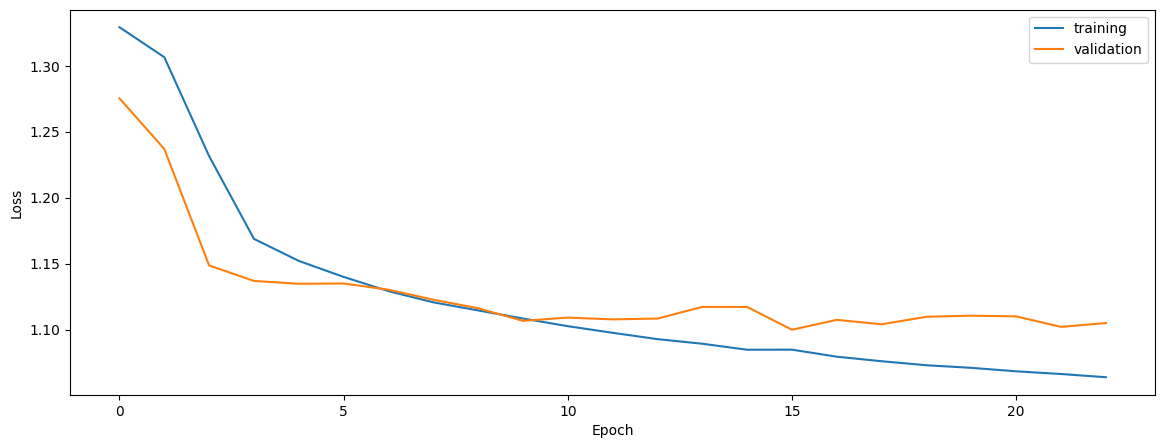

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.6336612256734783
0.6298889854614412
0.6397338403041825


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

normalized
0.6336612256734783
0.6298889854614412
0.6397338403041825


In [9]:
print('native')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6373827344464389
0.6374678402166554
0.6376006111400198


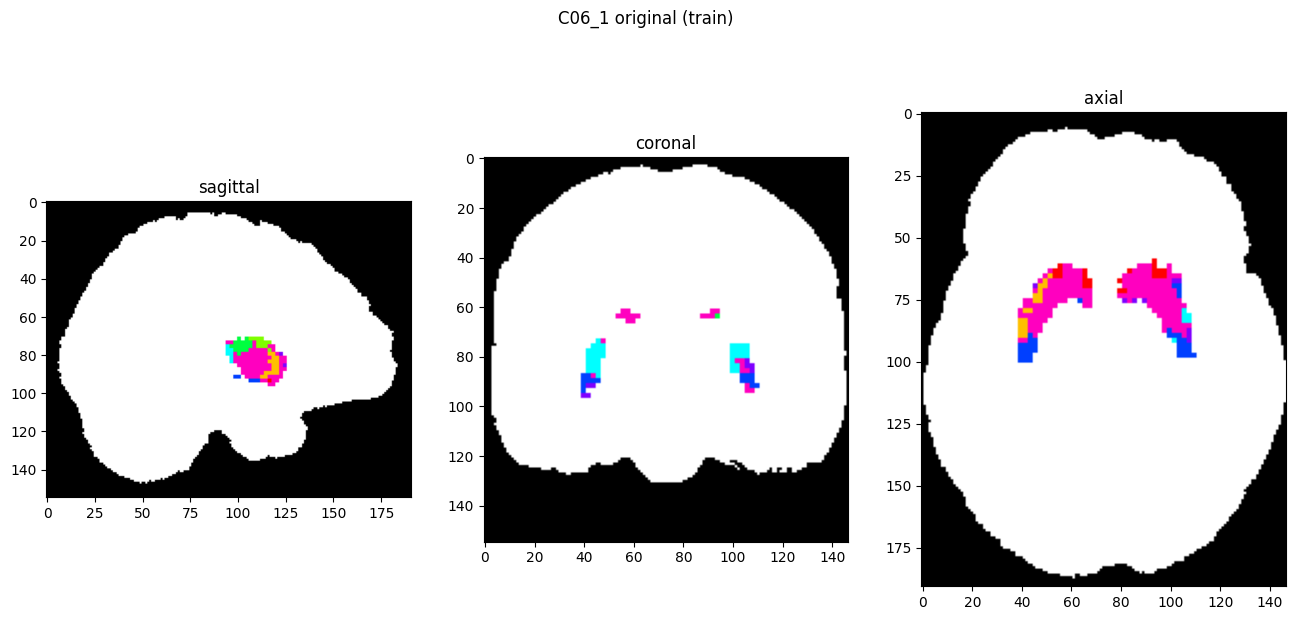

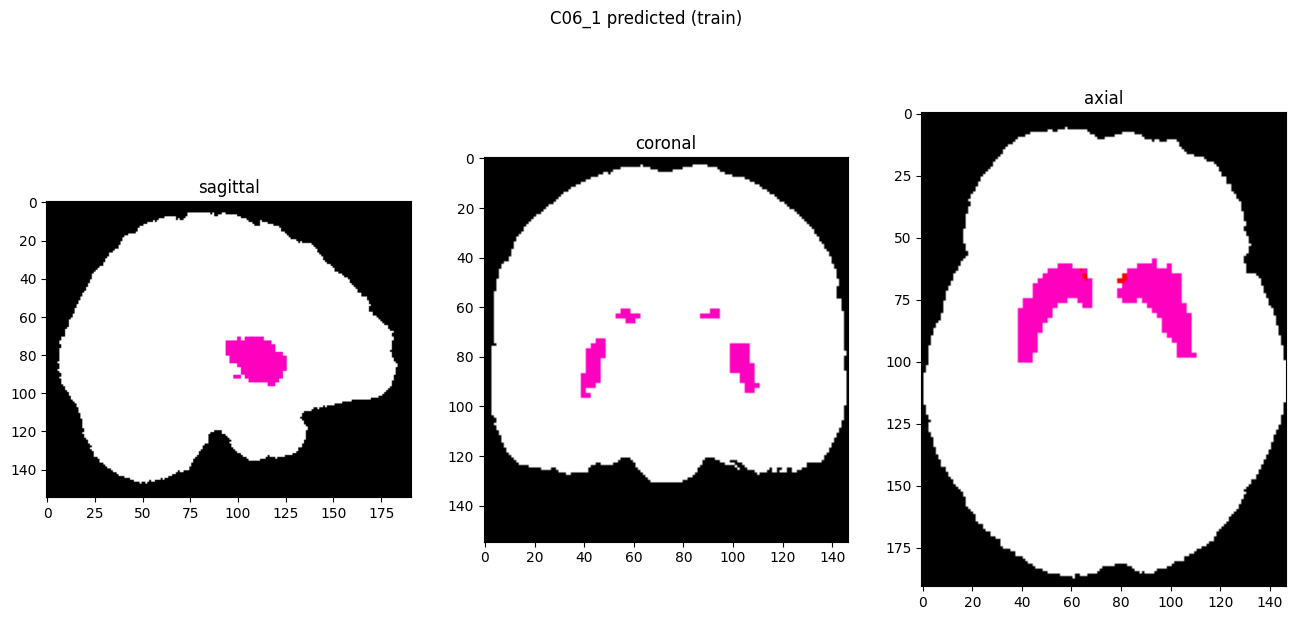

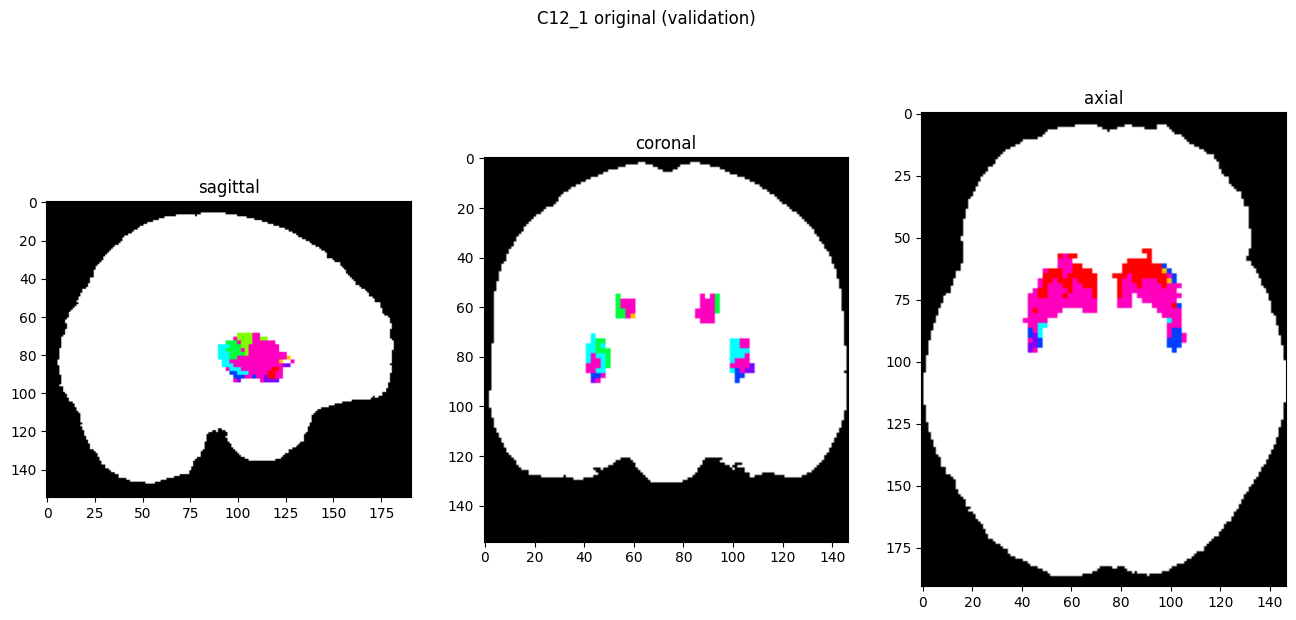

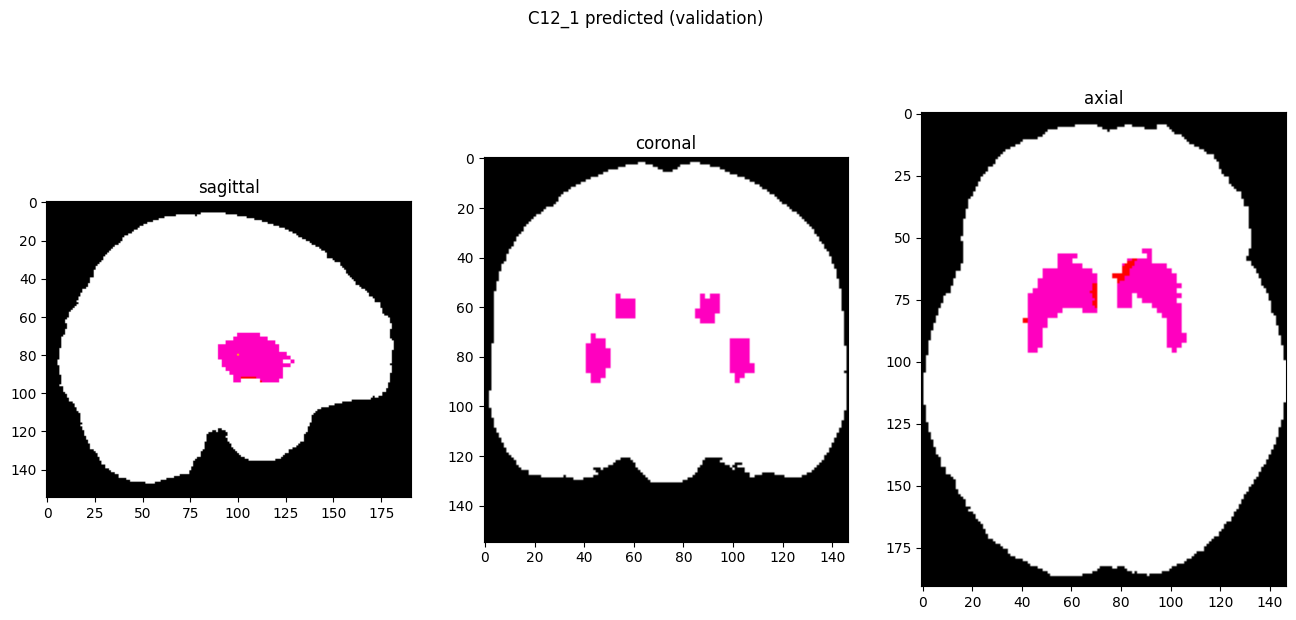

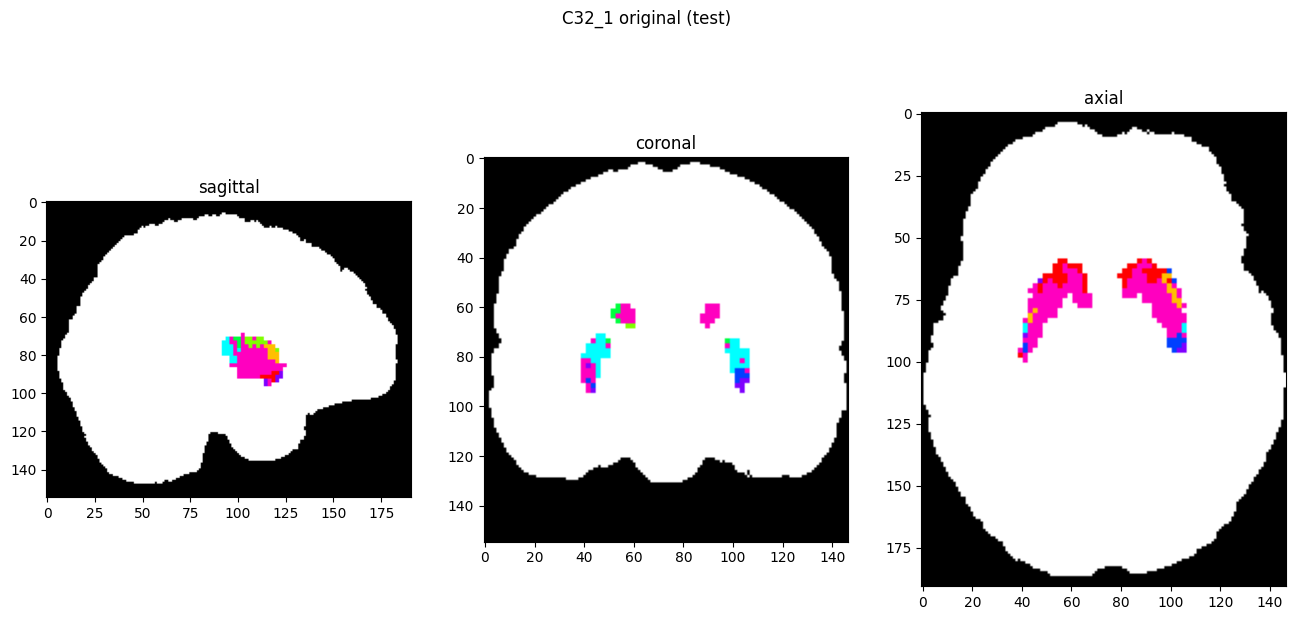

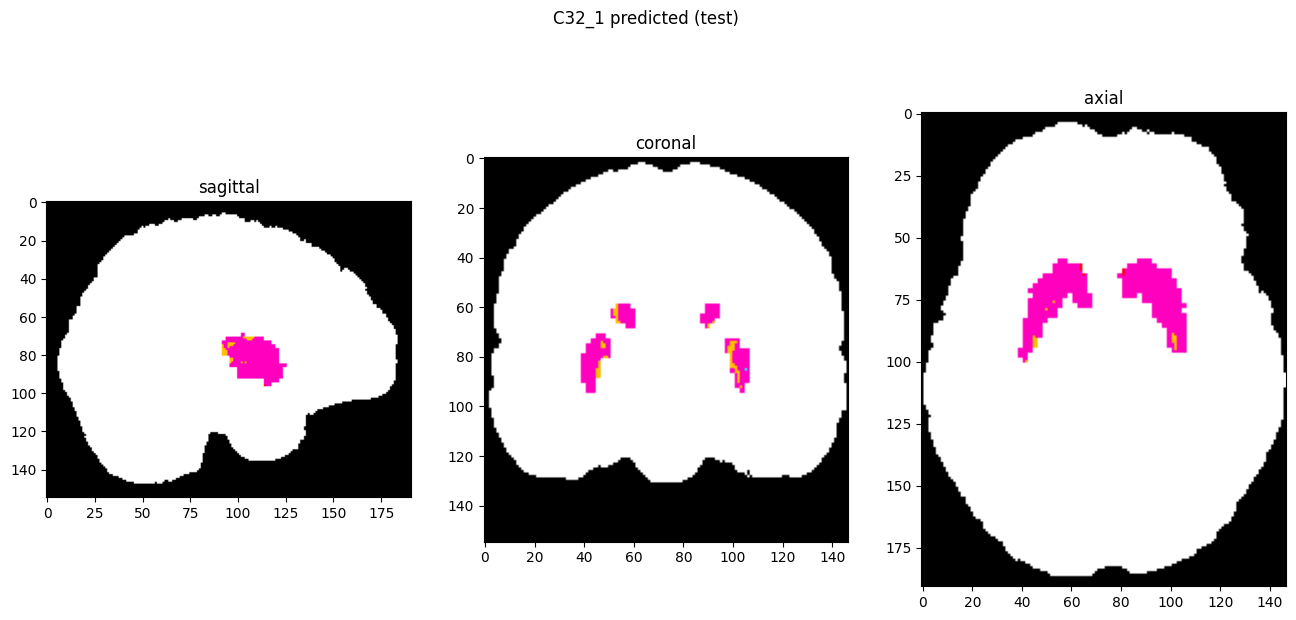

In [10]:
showResults(model, gen, threshold=0)